In [1]:
import numpy as np
import pandas as pd 
import math

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import pandas as pd
import numpy as np
import seaborn as sns
from itertools import cycle

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

In [2]:
calendar = pd.read_csv('calendar.csv')
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sample_submission = pd.read_csv('sample_submission.csv')
sell_prices = pd.read_csv('sell_prices.csv')

In [3]:
ids = sorted(list(set(sales_train_validation['id'])))
d_cols = [c for c in sales_train_validation.columns if 'd_' in c]
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[3]].set_index('id')[d_cols].values[0]
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[5]].set_index('id')[d_cols].values[0]
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[20]].set_index('id')[d_cols].values[0]
x_4 = sales_train_validation.loc[sales_train_validation['id'] == ids[67]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_4)), y=x_4, showlegend=False,
                    mode='lines', name="Fourth sample",
                         marker=dict(color="MediumPurple")),
             row=4, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

In [4]:
ids = sorted(list(set(sales_train_validation['id'])))
d_cols = [c for c in sales_train_validation.columns if 'd_' in c]
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[3]].set_index('id')[d_cols].values[0][:150]
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[5]].set_index('id')[d_cols].values[0][1215:1600]
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[20]].set_index('id')[d_cols].values[0][10:230]
x_4 = sales_train_validation.loc[sales_train_validation['id'] == ids[67]].set_index('id')[d_cols].values[0][550:700]

fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=True,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=True,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=True,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_4)), y=x_4, showlegend=True,
                    mode='lines+markers', name="Fourth sample",
                         marker=dict(color="MediumPurple")),
             row=4, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales fractions")
fig.show()

In [5]:
print("The shape of sales data:",sales_train_validation.shape)
print("The shape of sell_prices data:",sell_prices.shape)
print("The shape of calender data:",calendar.shape)

The shape of sales data: (30490, 1919)
The shape of sell_prices data: (6841121, 4)
The shape of calender data: (1969, 14)


In [6]:
print('States:',len(sales_train_validation['state_id'].unique()))
print('Stores:',len(sales_train_validation['store_id'].unique()))
print('Categories:',len(sales_train_validation['cat_id'].unique()))
print('Deptartments:',len(sales_train_validation['dept_id'].unique()))
print('Items:',len(sales_train_validation['item_id'].unique()))

States: 3
Stores: 10
Categories: 3
Deptartments: 7
Items: 3049


In [7]:
sales_group = sales_train_validation.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)
sales_group = sales_group['item_id'].count().dropna()
sales_group['USA'] = 'USA'

fig = px.treemap(sales_group, path=['USA', 'state_id', 'store_id', 'cat_id', 'dept_id'], values='item_id',
                  color='item_id',
                  color_continuous_scale = 'earth',
                  title='Details of items from Walmart')
            
fig.update_layout(treemapcolorway = ["pink", "lightgray"])
fig.show()

In [8]:
past_sales = sales_train_validation.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1').set_index('date')

store_list = sell_prices['store_id'].unique()

fig = go.Figure()
means = []
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))

fig.update_layout(xaxis_title="Time", yaxis_title="Sales", title='Rolling Average Sales vs. Time (per store) with window size:90' )
fig.show()

In [9]:
fig = go.Figure()

for i, s in enumerate(store_list):
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s))
        
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name ")

In [10]:
df = pd.DataFrame(np.transpose([means, store_list]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name")

In [11]:
store_list = sell_prices['store_id'].unique()
means = []
stores = []
fig = go.Figure()
for s in store_list:
    if 'ca' in s or 'CA' in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")

In [12]:
# data = np.transpose([means, stores])
# df = pd.DataFrame(data, columns=["Mean sales", "Stores"])
# px.bar(df, x="Stores", y="Mean sales", color="Stores", title="Stores vs Mean sales")

df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name")

In [13]:
store_list = sell_prices['store_id'].unique()
means = []
stores = []
fig = go.Figure()
for s in store_list:
    if 'wi' in s or 'WI' in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Wisconsin)")

In [14]:
fig = go.Figure()

for i, s in enumerate(store_list):
    if "wi" in s or "WI" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s,showlegend=True))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Store name", title="Rolling Average Sales vs. Store name (Wisconsin)")

In [15]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name")

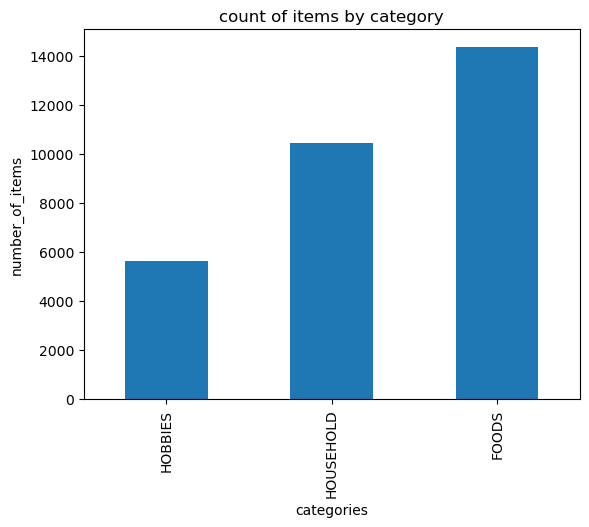

In [16]:
items_ids=(sales_train_validation.groupby('cat_id').count()['id'])
items_ids=items_ids.sort_values()
items_ids.plot(kind='bar', title='count of items by category')
plt.xlabel("categories")
plt.ylabel("number_of_items")
plt.show()

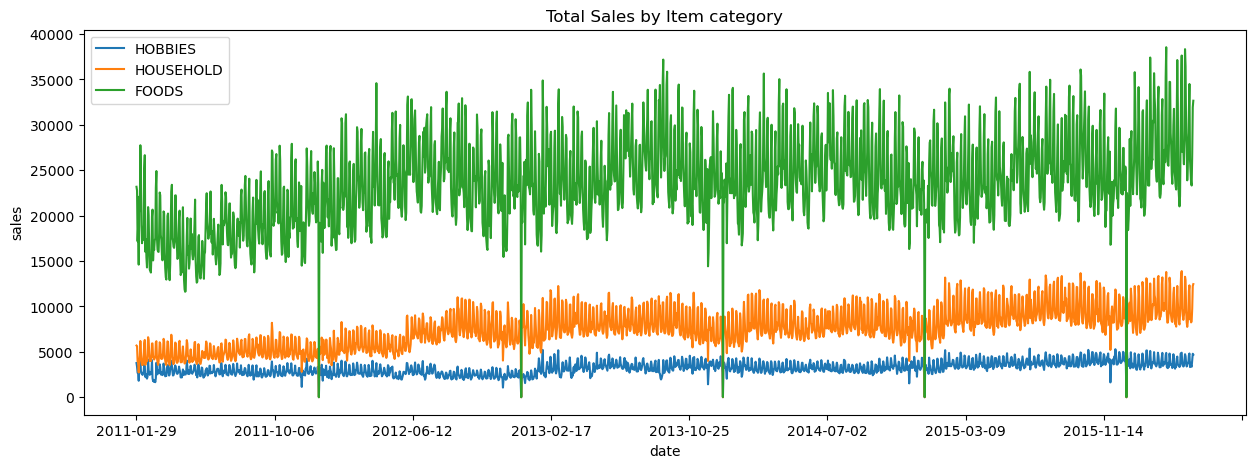

In [17]:
categories=sales_train_validation['cat_id'].unique()

for cat in categories:
  cat_cols=[]
  for c in past_sales.columns:
    if cat in c:
      cat_cols.append(c)
  past_sales[cat_cols].sum(axis=1).plot(figsize=(15, 5), title='Total Sales by Item category')

plt.legend(sales_train_validation['cat_id'].unique())
plt.ylabel("sales")
plt.show()

## Modeling LSTM


In [18]:
timesteps = 14
startDay = 350

In [19]:
df_sales = sales_train_evaluation
df_sales = df_sales.T
df_sales.head(10)

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
state_id,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0


In [20]:
df_sales = df_sales[6 + startDay:]
df_sales

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_351,0,0,0,2,0,0,0,24,3,2,...,0,9,1,0,11,0,0,1,0,0
d_352,0,0,0,0,0,0,0,9,0,2,...,0,5,4,0,8,0,1,2,0,0
d_353,0,0,0,4,2,0,0,2,1,1,...,0,15,2,0,3,0,1,2,0,0
d_354,0,1,0,2,0,0,0,7,1,0,...,0,5,1,0,3,0,0,0,0,0
d_355,0,0,0,1,2,0,0,0,0,0,...,0,7,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,0,0,0,1,0,0,1,5,0,1,...,3,6,3,0,0,1,0,1,0,0
d_1938,3,0,2,3,0,0,0,4,0,1,...,1,4,3,1,2,0,1,0,1,2
d_1939,3,0,3,0,2,5,1,1,0,0,...,3,4,3,1,1,0,0,1,1,2
d_1940,0,0,0,2,1,2,1,40,1,0,...,0,1,0,0,3,1,1,0,1,5


In [21]:
#Create dataframe with zeros for 1969 days in the calendar
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))

In [22]:
for x,y in calendar.iterrows():
    if((pd.isnull(calendar["event_name_1"][x])) == False):
        daysBeforeEvent[0][x-1] = 1

In [23]:
#"daysBeforeEventTest" will be used as input for predicting (We will forecast the days 1913-1941)
daysBeforeEventTest = daysBeforeEvent[1941:1969]
#"daysBeforeEvent" will be used for training as a feature.
daysBeforeEvent = daysBeforeEvent[startDay:1941]

In [24]:
#Before concatanation with our main data "dt", indexes are made same and column name is changed to "oneDayBeforeEvent"
daysBeforeEvent.columns = ["oneDayBeforeEvent"]
daysBeforeEvent.index = df_sales.index

In [25]:
df_sales = pd.concat([df_sales, daysBeforeEvent], axis = 1)
df_sales

,0,1,2,3,4,5,6,7,8,9,...,30481,30482,30483,30484,30485,30486,30487,30488,30489,oneDayBeforeEvent
d_351,0,0,0,2,0,0,0,24,3,2,...,9,1,0,11,0,0,1,0,0,0.0
d_352,0,0,0,0,0,0,0,9,0,2,...,5,4,0,8,0,1,2,0,0,1.0
d_353,0,0,0,4,2,0,0,2,1,1,...,15,2,0,3,0,1,2,0,0,0.0
d_354,0,1,0,2,0,0,0,7,1,0,...,5,1,0,3,0,0,0,0,0,0.0
d_355,0,0,0,1,2,0,0,0,0,0,...,7,1,0,1,0,1,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,0,0,0,1,0,0,1,5,0,1,...,6,3,0,0,1,0,1,0,0,0.0
d_1938,3,0,2,3,0,0,0,4,0,1,...,4,3,1,2,0,1,0,1,2,0.0
d_1939,3,0,3,0,2,5,1,1,0,0,...,4,3,1,1,0,0,1,1,2,0.0
d_1940,0,0,0,2,1,2,1,40,1,0,...,1,0,0,3,1,1,0,1,5,0.0


In [26]:
# 做minmax，第二行多df_sales.values
sc = MinMaxScaler(feature_range = (0, 1))
df_sales_scaled = sc.fit_transform(df_sales.values)

# X_train is the first 14 days, and the 15 day is y_train. I use 14 days to predict the 15 day.
X_train = []
y_train = []
for i in range(timesteps, 1941 - startDay):
    X_train.append(df_sales_scaled[i-timesteps:i])
    y_train.append(df_sales_scaled[i][0:30490]) 

In [27]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(1577, 14, 30491)
(1577, 30490)


Epoch 1/50
61/61 [==============================] - 27s 76ms/step - loss: 0.0189
Epoch 2/50
61/61 [==============================] - 5s 73ms/step - loss: 0.0154
Epoch 3/50
61/61 [==============================] - 5s 77ms/step - loss: 0.0149
Epoch 4/50
61/61 [==============================] - 6s 88ms/step - loss: 0.0146
Epoch 5/50
61/61 [==============================] - 6s 96ms/step - loss: 0.0145
Epoch 6/50
61/61 [==============================] - 8s 131ms/step - loss: 0.0142
Epoch 7/50
61/61 [==============================] - 14s 232ms/step - loss: 0.0140
Epoch 8/50
61/61 [==============================] - 20s 329ms/step - loss: 0.0138
Epoch 9/50
61/61 [==============================] - 22s 357ms/step - loss: 0.0140
Epoch 10/50
61/61 [==============================] - 20s 336ms/step - loss: 0.0138
Epoch 11/50
61/61 [==============================] - 23s 375ms/step - loss: 0.0136
Epoch 12/50
61/61 [==============================] - 22s 357ms/step - loss: 0.0136
Epoch 13/50
61/61 [====

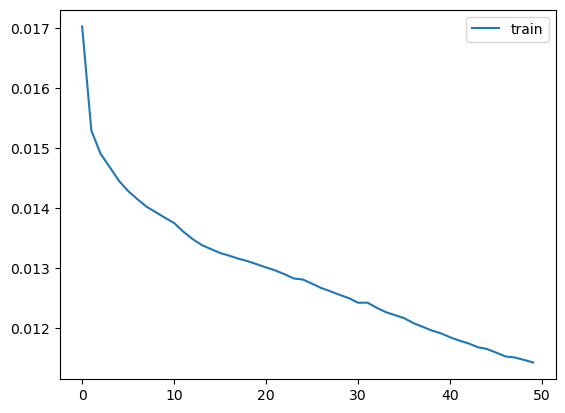

In [28]:
model = Sequential()

# 建立模型
layer_1_units=50
model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

layer_2_units=400
model.add(LSTM(units = layer_2_units, return_sequences = True))
model.add(Dropout(0.2))

layer_3_units=400
model.add(LSTM(units = layer_3_units))
model.add(Dropout(0.2))
model.add(Dense(units = 30490))

# 編譯模型
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 建立 ModelCheckpoint 回調函數
checkpoint = ModelCheckpoint('model_weights.h5', monitor='loss', save_best_only=True)

# 訓練模型
model.fit(X_train, y_train, epochs = 50, batch_size = 26, callbacks=[checkpoint])

# 繪製訓練和驗證損失的歷史記錄
plt.plot(model.history.history['loss'], label='train')
# plt.plot(model.history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [29]:
Lastdays = df_sales[-timesteps:]
Lastdays = sc.transform(Lastdays.values)

In [30]:
X_test = []
X_test.append(Lastdays[0:timesteps])
X_test = np.array(X_test)
predictions = []

for j in range(timesteps,timesteps + 28):
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = model.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 30491))
    testInput = np.column_stack((np.array(predicted_stock_price), daysBeforeEventTest[0][1941 + j - timesteps]))
    X_test = np.append(X_test, testInput).reshape(1,j + 1,30491)
    predicted_stock_price = sc.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_stock_price)

In [31]:
# pd.DataFrame(predicted_stock_price)
X_test

array([[[0.4       , 0.        , 0.        , ..., 0.08333333,
         0.08333333, 0.        ],
        [0.4       , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.2       , 0.        , 0.16666667, ..., 0.16666667,
         0.        , 0.        ],
        ...,
        [0.23931807, 0.03134311, 0.13748398, ..., 0.07577236,
         0.13516867, 0.        ],
        [0.31039432, 0.11895747, 0.18023238, ..., 0.07456795,
         0.16431876, 1.        ],
        [0.17007801, 0.13161997, 0.19579974, ..., 0.10454404,
         0.10729414, 0.        ]]])

In [32]:
import time

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))

submission = submission.T
    
submission = pd.concat((submission, submission), ignore_index=True)

sample_submission = pd.read_csv("sample_submission.csv")
    
idColumn = sample_submission[["id"]]
    
submission[["id"]] = idColumn  

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

colsdeneme = ["id"] + [f"F{i}" for i in range (1,29)]

submission.columns = colsdeneme

currentDateTime = time.strftime("%d%m%Y_%H%M%S")

submission.to_csv("submission3.csv", index=False)